In [9]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import statsmodels.formula.api as smf
import missingno as msno 





In [10]:
features = pd.read_csv("../0_DataPreparation/features.csv")
features

,id,Datum,Warengruppe,Umsatz,Bewoelkung,Temperatur,Windgeschwindigkeit,KielerWoche,CPI,Unemployment,...,Weather_Other,Weather_Rain,Weather_Showers_and_Thunderstorms,Weather_Snow_and_Ice,Group_brot,Group_brotchen,Group_croissant,Group_konditorei,Group_kuchen,Group_saisonbrot
0,1307011,2013-07-01,1,148.828353,6.0,17.8375,15.0,0,93.5,6.8,...,False,False,False,False,True,False,False,False,False,False
1,1307021,2013-07-02,1,159.793757,3.0,17.3125,10.0,0,93.5,6.8,...,True,False,False,False,True,False,False,False,False,False
2,1307031,2013-07-03,1,111.885594,7.0,21.0750,6.0,0,93.5,6.8,...,False,True,False,False,True,False,False,False,False,False
3,1307041,2013-07-04,1,168.864941,7.0,18.8500,7.0,0,93.5,6.8,...,False,False,False,False,True,False,False,False,False,False
4,1307051,2013-07-05,1,171.280754,5.0,19.9750,12.0,0,93.5,6.8,...,True,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11159,1812226,2018-12-22,6,NaN,8.0,4.3000,4.0,0,98.5,4.9,...,True,False,False,False,False,False,False,False,False,True
11160,1812236,2018-12-23,6,NaN,7.0,6.4500,9.0,0,98.5,4.9,...,False,True,False,False,False,False,False,False,False,True
11161,1812246,2018-12-24,6,NaN,7.0,2.5000,10.0,0,98.5,4.9,...,False,False,False,False,False,False,False,False,False,True
11162,1812276,2018-12-27,6,NaN,7.0,7.1250,12.0,0,98.5,4.9,...,False,False,False,False,False,False,False,False,False,True


<Axes: >

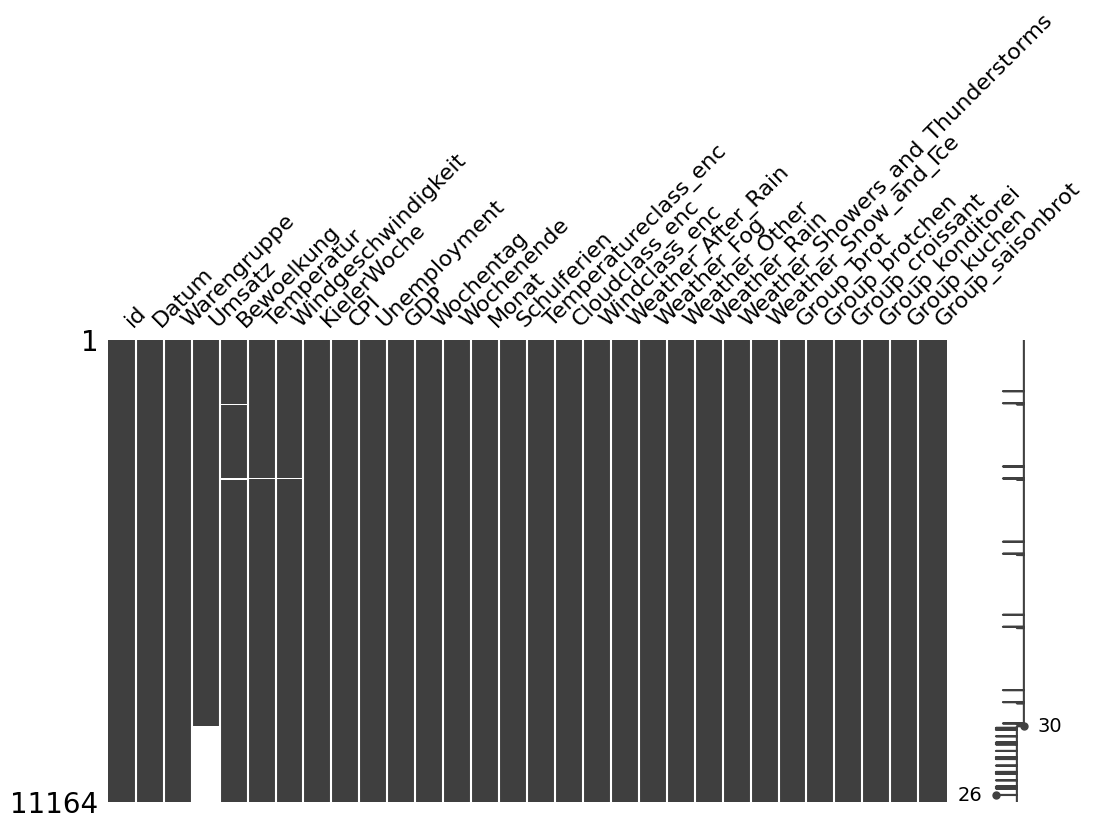

In [11]:
msno.matrix(features, figsize=(12, 6))

## Time Split
We Split the dataset into training, validation and test data

In [12]:
train_end_date = '2017-07-31'
validation_end_date = '2018-07-31'


train_data = features[features['Datum']<=train_end_date].set_index("id")
vali_data = features[(features['Datum']> train_end_date) & (features['Datum']<=validation_end_date)].set_index("id")
test_data = features[(features['Datum']> validation_end_date)].set_index("id")


## Feature Selection
Define differnt groups of features for testing.

In [13]:
# Set 'id' as index
df = train_data

# Drop rows with missing values for simplicity in this baseline modeling
df_clean = df.dropna()

groups = {
    "Zeit" : "Wochentag + Monat + Wochenende",
    "Wetter" : "Temperatureclass_enc + Cloudclass_enc + Windclass_enc ",
    "Wetter_Group" : "Weather_Other + Weather_Rain + Weather_After_Rain + Weather_Showers_and_Thunderstorms + Weather_Snow_and_Ice + Weather_Fog",
    "Product" : "Warengruppe + Group_brot + Group_brotchen + Group_croissant + Group_konditorei + Group_kuchen + Group_saisonbrot",
    "Ökonomie": "CPI + Unemployment + GDP",
    "Holiday" : "Schulferien + KielerWoche"
}

# Define a list of formulas for different baseline models
formulas = {
    "Zeit": f"Umsatz ~ {groups['Zeit']}",
    "Wetter": f"Umsatz ~ {groups['Wetter']}",
    "Product": f"Umsatz ~ {groups['Product']}",
    "Ökonomie": f"Umsatz ~ {groups['Ökonomie']}",
    "Zeit+Wetter": f"Umsatz ~ {groups['Zeit']} + {groups['Wetter']}",
    "Zeit+Product": f"Umsatz ~ {groups['Zeit']} + {groups['Product']}",
    "Zeit+Ökonomie": f"Umsatz ~ {groups['Zeit']} + {groups['Ökonomie']}",
    "Zeit+Holiday": f"Umsatz ~ {groups['Zeit']} + {groups['Holiday']}",
    "Zeit+Wetter+Product": f"Umsatz ~ {groups['Zeit']} + {groups['Wetter']} + {groups['Product']}",
    "Vollmodell": f"Umsatz ~ {groups['Zeit']} + {groups['Wetter']} + {groups['Product']} + {groups['Ökonomie']} + {groups['Holiday']}",
    "Vollmodell+": f"Umsatz ~ {groups['Zeit']} + {groups['Wetter']} + {groups['Wetter_Group']} + {groups['Product']} + {groups['Ökonomie']} + {groups['Holiday']}"
}

# Fit models and collect performance metrics
results = []
for name, formula in formulas.items():
    model = smf.ols(formula, data=df_clean).fit()
    results.append({
        "Modell": name,
        "R²": round(model.rsquared, 4),
        "AIC": round(model.aic, 2),
        "BIC": round(model.bic, 2),
        "Anzahl Parameter": int(model.df_model + 1)
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by="R²", ascending=False)
results_df

,Modell,R²,AIC,BIC,Anzahl Parameter
10,Vollmodell+,0.7366,86106.06,86258.32,22
9,Vollmodell,0.7365,86098.95,86216.60,17
8,Zeit+Wetter+Product,0.7088,86838.19,86921.24,12
5,Zeit+Product,0.6798,87542.79,87605.08,9
2,Product,0.6503,88195.95,88237.47,6
4,Zeit+Wetter,0.0664,95550.88,95599.32,7
7,Zeit+Holiday,0.0614,95588.97,95630.50,6
6,Zeit+Ökonomie,0.0546,95645.16,95693.61,7
1,Wetter,0.0423,95735.34,95763.03,4
3,Ökonomie,0.0268,95856.09,95883.78,4


## Create the baseline model

In [14]:
model = smf.ols(formulas['Vollmodell+'], data=train_data.dropna()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Umsatz   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     994.3
Date:                Tue, 24 Jun 2025   Prob (F-statistic):               0.00
Time:                        22:23:44   Log-Likelihood:                -43031.
No. Observations:                7487   AIC:                         8.611e+04
Df Residuals:                    7465   BIC:                         8.626e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                  -745.2157    126.669     -5.883      0.000    -993.523    -496.908
Weather_Other[T.True]                      -127.3762     21.167     -6.018      0.000    -168.869     -85.883
Weather_Rain[T.True]                       -127.4795     21.178     -6.019      0.000    -168.995     -85.964
Weather_After_Rain[T.True]                 -126.5909     21.185     -5.976      0.000    -168.119     -85.063
Weather_Showers_and_Thunderstorms[T.True]  -119.1272     22.231     -5.359      0.000    -162.706     -75.548
Weather_Snow_and_Ice[T.True]               -117.8978     21.951     -5.371      0.000    -160.928     -74.868
Weather_Fog[T.True]                        -126.7440     21.475     -5.902      0.000    -168.841     -84.647
Group_brot[T.True]                         -590.5710     81.009     -7.290      0.000    -749.371    -431.771
Group_brotchen[T.True]                     -143.1313     57.077     -2.508      0.012    -255.018     -31.244
Group_croissant[T.True]                    -231.2631     33.164     -6.973      0.000    -296.274    -166.252
Group_konditorei[T.True]                   -147.9524      9.416    -15.712      0.000    -166.411    -129.494
Group_kuchen[T.True]                        202.0557     14.969     13.498      0.000     172.712     231.399
Group_saisonbrot[T.True]                    165.6464     38.984      4.249      0.000      89.227     242.066
Wochentag                                     1.4221      0.720      1.976      0.048       0.011       2.833
Monat                                         2.4081      0.399      6.042      0.000       1.627       3.189
Wochenende                                   47.4198      3.193     14.850      0.000      41.160      53.679
Temperatureclass_enc                         23.4342      1.552     15.101      0.000      20.392      26.476
Cloudclass_enc                                4.9913      2.151      2.320      0.020       0.774       9.209
Windclass_enc                                 0.9271      0.934      0.993      0.321      -0.903       2.757
Warengruppe                                -158.2758     23.951     -6.608      0.000    -205.226    -111.326
CPI                                          18.5273      2.521      7.349      0.000      13.585      23.469
Unemployment                                 35.1920      6.413      5.488      0.000      22.621      47.763
GDP                                          -0.4416      0.073     -6.079      0.000      -0.584      -0.299
Schulferien                                  48.0354      2.242     21.429      0.000      43.641      52.430
KielerWoche                                  33.1560      6.129      5.410      0.000      21.142      45.170
===

## Make a prediction

In [15]:
pred = model.predict(test_data).clip(lower=0)
pred_df = pred.rename("Umsatz").reset_index()
pred_df.to_csv("kaggle_baseline.csv", index=False)
